In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

def preparar_dados(df):
    """Prepara os dados iniciais com tratamento robusto do target"""
    # Converter data
    df['data_pregao'] = pd.to_datetime(df['data_pregao'])
    
    # Ordenar por ação e data
    df = df.sort_values(['cod_negociacao', 'data_pregao'])
    
    # Calcular retorno futuro de forma segura
    df['retorno_futuro'] = df.groupby('cod_negociacao')['preco_fechamento'].transform(
        lambda x: x.pct_change(periods=52)
    )
    
    # Remover retornos extremos (outliers)
    df['retorno_futuro'] = df['retorno_futuro'].clip(
        lower=df['retorno_futuro'].quantile(0.01),
        upper=df['retorno_futuro'].quantile(0.99)
    )
    
    return df

def extrair_features(df):
    """Extrai features com tratamento completo de infinitos e NA"""
    df = df.copy()
    
    # Garantir ordenação
    df = df.sort_values(['cod_negociacao', 'data_pregao'])
    
    # Grupo para cálculos
    gb = df.groupby('cod_negociacao')['preco_fechamento']
    
    # Função segura para retornos
    def safe_return(current, past, min_price=0.01):
        with np.errstate(divide='ignore', invalid='ignore'):
            return np.where(
                (past > min_price) & (current > min_price),
                (current - past) / past,
                np.nan
            )
    
    # Médias móveis
    for window in [4, 8, 12, 26]:
        df[f'media_{window}w'] = gb.rolling(window=window).mean().reset_index(level=0, drop=True)
        df[f'vol_{window}w'] = gb.rolling(window=window).std().reset_index(level=0, drop=True)
    
    # Retornos protegidos
    for weeks, periods in [(4,3), (12,11), (26,25)]:
        preco_passado = gb.shift(periods)
        df[f'retorno_{weeks}w'] = safe_return(df['preco_fechamento'], preco_passado)
    
    # Volume médio
    vol_gb = df.groupby('cod_negociacao')['volume']
    for window in [4, 12]:
        df[f'volume_medio_{window}w'] = vol_gb.rolling(window=window).mean().reset_index(level=0, drop=True)
    
    # Momentum com fillna
    df['momento_4_12'] = (df['retorno_4w'].fillna(0) - df['retorno_12w'].fillna(0))
    
    return df

def clean_data(X, y):
    """Limpeza final dos dados antes do treino"""
    # Juntar X e y para limpeza consistente
    data = X.copy()
    data['target'] = y
    
    # Remover infinitos e NA
    data = data.replace([np.inf, -np.inf], np.nan)
    data = data.dropna()
    
    # Separar novamente
    X_clean = data.drop('target', axis=1)
    y_clean = data['target']
    
    return X_clean, y_clean

def treinar_modelo(df):
    """Função final de treino com todas as proteções"""
    # Preparação dos dados
    df = preparar_dados(df)
    df = extrair_features(df)
    
    # Features selecionadas
    features = ['media_4w', 'media_12w', 'vol_4w', 'vol_12w', 
                'retorno_4w', 'retorno_12w', 'volume_medio_4w',
                'momento_4_12']
    
    X = df[features]
    y = df['retorno_futuro']
    
    # Limpeza final
    X, y = clean_data(X, y)
    
    # Pipeline robusto
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(
            n_estimators=200,
            random_state=42,
            n_jobs=-1,
            max_depth=5  # Limite de profundidade para evitar overfitting
        ))
    ])
    
    # Validação cruzada temporal
    tscv = TimeSeriesSplit(n_splits=3)  # Reduzido para 3 por performance
    
    print(f"Shape final dos dados: {X.shape}")
    print(f"Valores únicos no target: {pd.Series(y).describe()}")
    
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        pipeline.fit(X_train, y_train)
        score = pipeline.score(X_test, y_test)
        print(f"Score R²: {score:.4f}")
    
    return pipeline

# Carregar dados
df_semanal = pd.read_csv("semanal2021-2022.csv")

# Treinar modelo
modelo = treinar_modelo(df_semanal)

Shape final dos dados: (90838, 8)
Valores únicos no target: count    90838.000000
mean        -0.162388
std          0.417102
min         -0.958333
25%         -0.392035
50%         -0.172221
75%          0.000139
max          2.000000
Name: target, dtype: float64
Score R²: 0.1506
Score R²: 0.2112
Score R²: 0.1979


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt

class FeatureExtractor(BaseEstimator, TransformerMixin):
    """Classe para extração avançada de features sem TA-Lib"""
    def __init__(self):
        self.features_to_use = []
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, df):
        df = df.copy()
        
        # Garantir ordenação correta
        df = df.sort_values(['cod_negociacao', 'data_pregao'])
        
        # Grupo para cálculos
        gb = df.groupby('cod_negociacao')['preco_fechamento']
        
        # 1. Features básicas
        for window in [4, 8, 12, 26]:
            df[f'media_{window}w'] = gb.rolling(window=window).mean().reset_index(level=0, drop=True)
            df[f'vol_{window}w'] = gb.rolling(window=window).std().reset_index(level=0, drop=True)
        
        # 2. Retornos com tratamento robusto
        def safe_return(current, past, min_price=0.01):
            with np.errstate(divide='ignore', invalid='ignore'):
                return np.where(
                    (past > min_price) & (current > min_price),
                    (current - past) / past,
                    np.nan
                )
        
        for weeks, periods in [(1,0), (4,3), (12,11), (26,25)]:
            preco_passado = gb.shift(periods)
            df[f'retorno_{weeks}w'] = safe_return(df['preco_fechamento'], preco_passado)
        
        # 3. Implementação simplificada de RSI sem TA-Lib
        def calculate_rsi(series, window=14):
            delta = series.diff()
            gain = delta.where(delta > 0, 0)
            loss = -delta.where(delta < 0, 0)
            
            avg_gain = gain.rolling(window=window).mean()
            avg_loss = loss.rolling(window=window).mean()
            
            rs = avg_gain / avg_loss
            return 100 - (100 / (1 + rs))
        
        df['rsi_14'] = df.groupby('cod_negociacao')['preco_fechamento'].transform(calculate_rsi)
        
        # 4. Features temporais
        for lag in [1, 2, 3, 4]:
            df[f'retorno_lag_{lag}w'] = df.groupby('cod_negociacao')['retorno_1w'].shift(lag)
        
        df['ema_12'] = df.groupby('cod_negociacao')['preco_fechamento'].transform(
            lambda x: x.ewm(span=12).mean()
        )
        
        # 5. Features de volume
        vol_gb = df.groupby('cod_negociacao')['volume']
        for window in [4, 12]:
            df[f'volume_medio_{window}w'] = vol_gb.rolling(window=window).mean().reset_index(level=0, drop=True)
        
        # 6. Features setoriais/relativas (se disponível)
        if 'setor' in df.columns:
            df['retorno_relativo'] = df.groupby(['data_pregao', 'setor'])['retorno_4w'].transform('mean')
            df['vol_relativa'] = df['vol_4w'] / df.groupby('data_pregao')['vol_4w'].transform('mean')
        
        # Definir features a serem usadas
        self.features_to_use = [
            'media_4w', 'media_12w', 'vol_4w', 'vol_12w',
            'retorno_1w', 'retorno_4w', 'retorno_12w',
            'retorno_lag_1w', 'retorno_lag_2w',
            'volume_medio_4w', 'ema_12', 'rsi_14'
        ]
        
        if 'retorno_relativo' in df.columns:
            self.features_to_use.extend(['retorno_relativo', 'vol_relativa'])
        
        return df

# [O resto do código permanece igual a partir da função preparar_target()...]

def preparar_target(df):
    """Prepara o target com tratamento robusto"""
    df = df.sort_values(['cod_negociacao', 'data_pregao'])
    
    # Calcular retorno futuro
    df['retorno_futuro'] = df.groupby('cod_negociacao')['preco_fechamento'].transform(
        lambda x: x.pct_change(periods=52)
    )
    
    # Tratar outliers extremos
    lower = df['retorno_futuro'].quantile(0.01)
    upper = df['retorno_futuro'].quantile(0.99)
    df['retorno_futuro'] = df['retorno_futuro'].clip(lower, upper)
    
    return df

# [Continue com as outras funções: clean_data, criar_pipeline, avaliar_modelo, plot_feature_importance, main]
def clean_data(X, y):
    """Limpeza final dos dados"""
    data = X.join(y)
    data = data.replace([np.inf, -np.inf], np.nan)
    data = data.dropna()
    return data.drop('retorno_futuro', axis=1), data['retorno_futuro']

def criar_pipeline():
    """Cria pipeline de modelagem avançada"""
    return Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', HistGradientBoostingRegressor(
            max_iter=200,
            learning_rate=0.05,
            max_depth=7,
            early_stopping=True,
            random_state=42,
            scoring='r2'
        ))
    ])

def avaliar_modelo(X, y):
    """Avaliação robusta com validação cruzada temporal"""
    modelo = criar_pipeline()
    tscv = TimeSeriesSplit(n_splits=3)
    
    scores = cross_val_score(
        modelo, X, y,
        cv=tscv,
        scoring='r2',
        n_jobs=-1
    )
    
    print("\nResultados da Validação Cruzada:")
    for i, score in enumerate(scores):
        print(f"Fold {i+1}: R² = {score:.4f}")
    print(f"Média R²: {np.mean(scores):.4f} (±{np.std(scores):.4f})")
    
    return scores

def plot_feature_importance(modelo, feature_names):
    """Visualização correta da importância das features para qualquer modelo"""
    try:
        # Verifica se é um pipeline ou modelo direto
        if hasattr(modelo, 'named_steps'):
            model = modelo.named_steps['model']
        else:
            model = modelo
        
        # Obtém as importâncias de forma genérica
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importances = np.abs(model.coef_)
        else:
            print("Modelo não possui atributo de importância de features")
            return
        
        # Ordena as features por importância
        indices = np.argsort(importances)
        
        # Plot
        plt.figure(figsize=(10, 6))
        plt.title('Importância das Features')
        plt.barh(range(len(indices)), importances[indices], align='center')
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel('Importância Relativa')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Erro ao plotar importância: {str(e)}")

def main(file_path):
    """Função principal para execução completa sem TA-Lib"""
    # 1. Carregar dados
    print("Carregando dados...")
    df = pd.read_csv(file_path)
    
    # 2. Preparar target
    print("\nPreparando target...")
    df = preparar_target(df)
    
    # 3. Extrair features
    print("\nExtraindo features...")
    feature_extractor = FeatureExtractor()
    df_features = feature_extractor.transform(df)
    
    # 4. Selecionar dados finais
    X = df_features[feature_extractor.features_to_use]
    y = df_features['retorno_futuro']
    
    # 5. Limpeza final
    print("\nLimpando dados...")
    X_clean, y_clean = clean_data(X, y)
    
    print(f"\nShape final dos dados: {X_clean.shape}")
    print(f"Distribuição do target:\n{y_clean.describe()}")
    
    # 6. Avaliar modelo
    print("\nAvaliando modelo...")
    scores = avaliar_modelo(X_clean, y_clean)
    
    # 7. Treinar modelo final
    print("\nTreinando modelo final...")
    modelo = criar_pipeline()
    modelo.fit(X_clean, y_clean)
    
    # 8. Visualizar importância das features
    plot_feature_importance(modelo, feature_extractor.features_to_use)
    
    return modelo, X_clean, y_clean

if __name__ == "__main__":
    # Executar pipeline completo sem TA-Lib
    modelo_final, X_final, y_final = main("datasets/semanal2021-2022.csv")

Carregando dados...

Preparando target...

Extraindo features...

Limpando dados...

Shape final dos dados: (90752, 12)
Distribuição do target:
count    90752.000000
mean        -0.162085
std          0.416844
min         -0.958333
25%         -0.391588
50%         -0.172014
75%          0.000265
max          2.000000
Name: retorno_futuro, dtype: float64

Avaliando modelo...

Resultados da Validação Cruzada:
Fold 1: R² = 0.1395
Fold 2: R² = 0.2309
Fold 3: R² = 0.2150
Média R²: 0.1951 (±0.0399)

Treinando modelo final...
Modelo não possui atributo de importância de features


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import r2_score
import pickle

class FeatureExtractor(BaseEstimator, TransformerMixin):
    """Classe para extração avançada de features"""
    def __init__(self):
        self.features_to_use = []
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, df):
        df = df.copy()
        
        # Garantir ordenação correta
        if 'data_pregao' in df.columns:
            df['data_pregao'] = pd.to_datetime(df['data_pregao'])
            df = df.sort_values(['cod_negociacao', 'data_pregao'])
        
        # Grupo para cálculos
        gb = df.groupby('cod_negociacao')['preco_fechamento']
        
        # 1. Médias móveis e volatilidade
        for window in [4, 8, 12, 26]:
            df[f'media_{window}w'] = gb.rolling(window=window).mean().reset_index(level=0, drop=True)
            df[f'vol_{window}w'] = gb.rolling(window=window).std().reset_index(level=0, drop=True)
        
        # 2. Retornos protegidos contra divisão por zero
        def safe_return(current, past, min_price=0.01):
            with np.errstate(divide='ignore', invalid='ignore'):
                return np.where(
                    (past > min_price) & (current > min_price),
                    (current - past) / past,
                    np.nan
                )
        
        for weeks, periods in [(1,0), (4,3), (12,11), (26,25)]:
            preco_passado = gb.shift(periods)
            df[f'retorno_{weeks}w'] = safe_return(df['preco_fechamento'], preco_passado)
        
        # 3. RSI manual (sem TA-Lib)
        def calculate_rsi(series, window=14):
            delta = series.diff()
            gain = delta.where(delta > 0, 0)
            loss = -delta.where(delta < 0, 0)
            
            avg_gain = gain.rolling(window=window, min_periods=1).mean()
            avg_loss = loss.rolling(window=window, min_periods=1).mean()
            
            rs = avg_gain / avg_loss.replace(0, np.nan)
            return 100 - (100 / (1 + rs.replace(np.inf, 100)))
        
        df['rsi_14'] = df.groupby('cod_negociacao')['preco_fechamento'].transform(calculate_rsi)
        
        # 4. Features temporais
        for lag in [1, 2, 3, 4]:
            df[f'retorno_lag_{lag}w'] = df.groupby('cod_negociacao')['retorno_1w'].shift(lag)
        
        df['ema_12'] = df.groupby('cod_negociacao')['preco_fechamento'].transform(
            lambda x: x.ewm(span=12).mean()
        )
        
        # 5. Features de volume
        if 'volume' in df.columns:
            vol_gb = df.groupby('cod_negociacao')['volume']
            for window in [4, 12]:
                df[f'volume_medio_{window}w'] = vol_gb.rolling(window=window).mean().reset_index(level=0, drop=True)
        
        # Definir features a serem usadas
        self.features_to_use = [
            'media_4w', 'media_12w', 'vol_4w', 'vol_12w',
            # 'retorno_1w',
            'retorno_4w', 'retorno_12w',
            # 'retorno_lag_1w', 'retorno_lag_2w',
            'volume_medio_4w', 'ema_12', 'rsi_14'
        ]
        
        return df

def preparar_target(df):
    """Prepara o target com tratamento robusto"""
    df = df.sort_values(['cod_negociacao', 'data_pregao'])
    
    # Calcular retorno futuro de 52 semanas
    df['retorno_futuro'] = df.groupby('cod_negociacao')['preco_fechamento'].transform(
        lambda x: x.pct_change(periods=52)
    )
    
    # Remover outliers extremos
    if 'retorno_futuro' in df.columns:
        lower = df['retorno_futuro'].quantile(0.01)
        upper = df['retorno_futuro'].quantile(0.99)
        df['retorno_futuro'] = df['retorno_futuro'].clip(lower, upper)

    return df

def clean_data(X, y):
    """Limpeza final dos dados"""
    data = X.join(y)
    data = data.replace([np.inf, -np.inf], np.nan)
    data = data.dropna()
    return data.drop('retorno_futuro', axis=1), data['retorno_futuro']

def criar_pipeline_xgb():
    """Pipeline com XGBoost otimizado"""
    return Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', XGBRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.9,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            eval_metric='rmse'
        ))
    ])

def treinar_avaliar_xgb(X, y):
    """Treinamento e avaliação personalizada com validação temporal"""
    tscv = TimeSeriesSplit(n_splits=3)
    scores = []
    modelos = []
    
    for train_index, test_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        
        # Criar e treinar modelo
        xgb = XGBRegressor(
            n_estimators=500,  # Número maior pois usamos early stopping
            learning_rate=0.05,
            max_depth=6,
            subsample=0.9,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            early_stopping_rounds=20,
            eval_metric='rmse'
        )
        
        # Treinar com early stopping
        xgb.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        
        # Avaliar
        y_pred = xgb.predict(X_val)
        score = r2_score(y_val, y_pred)
        scores.append(score)
        modelos.append(xgb)
        
        print(f"Fold {len(scores)}: R² = {score:.4f} | Melhor iteração: {xgb.best_iteration}")
    
    print(f"\nR² Médio: {np.mean(scores):.4f} (±{np.std(scores):.4f})")
    return modelos, scores

def plot_xgb_importance(modelo, feature_names):
    """Visualização da importância das features no XGBoost"""
    importances = modelo.feature_importances_
    
    # Cria DataFrame para melhor visualização
    feat_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance')
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(feat_imp)), feat_imp['Importance'], align='center')
    plt.yticks(range(len(feat_imp)), feat_imp['Feature'])
    plt.title('Importância das Features - XGBoost')
    plt.xlabel('Importância Relativa')
    plt.tight_layout()
    plt.show()

def main(file_path):
    """Função principal"""
    try:
        # 1. Carregar dados
        print("Carregando dados...")
        df = pd.read_csv(file_path)
        
        # 2. Preparar target
        print("\nPreparando target...")
        df = preparar_target(df)
        
        # 3. Extrair features
        print("\nExtraindo features...")
        feature_extractor = FeatureExtractor()
        df_features = feature_extractor.transform(df)
        
        # 4. Selecionar dados finais
        X = df_features[feature_extractor.features_to_use]
        y = df_features['retorno_futuro']
        
        # 5. Limpeza final
        print("\nLimpando dados...")
        X_clean, y_clean = clean_data(X, y)
        
        print(f"\nDados finais: {X_clean.shape[0]} observações")
        print(f"Features: {X_clean.shape[1]} variáveis")
        
        # 6. Treinar e avaliar
        print("\nTreinando XGBoost com validação temporal...")
        modelos, scores = treinar_avaliar_xgb(X_clean, y_clean)
        
        # 7. Treinar modelo final com todos os dados
        print("\nTreinando modelo final...")
        modelo_final = XGBRegressor(
            n_estimators=int(np.mean([m.best_iteration for m in modelos])) + 20,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.9,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        )
        modelo_final.fit(X_clean, y_clean)
        
        # 8. Visualizar importância
        plot_xgb_importance(modelo_final, feature_extractor.features_to_use)

        # 9. Salvar o modelo treinado
        print("\nSalvando modelo treinado...")
        modelo_final.save_model('modelo_xgb_treinado.json')
        
        # Salvar também o feature extractor
        print(feature_extractor)
        print(df_features)
        with open('feature_extractor.pkl', 'wb') as file:
            pickle.dump(feature_extractor, file)
        
        print("Modelo e feature extractor salvos com sucesso!")
        
        return modelo_final, X_clean, y_clean
    
    except Exception as e:
        print(f"\nErro: {str(e)}")
        return None, None, None

if __name__ == "__main__":
    # Executar pipeline
    modelo_xgb, X_data, y_data = main("datasets/semanal2021-2022.csv")
    
    if modelo_xgb is not None:
        print("\nModelo XGBoost treinado com sucesso!")
        # Exemplo de previsão
        sample_pred = modelo_xgb.predict(X_data.head(1))
        print(f"Exemplo de previsão para a primeira amostra: {sample_pred[0]:.4f}")

Carregando dados...

Preparando target...


Carregando dados...

Preparando target...

Extraindo features...

Limpando dados...

Dados finais: 47999 observações
Features: 9 variáveis

Treinando XGBoost com validação temporal...
Fold 1: R² = 0.1279 | Melhor iteração: 21
Fold 2: R² = 0.2911 | Melhor iteração: 69
Fold 3: R² = 0.2419 | Melhor iteração: 88

R² Médio: 0.2203 (±0.0683)

Treinando modelo final...


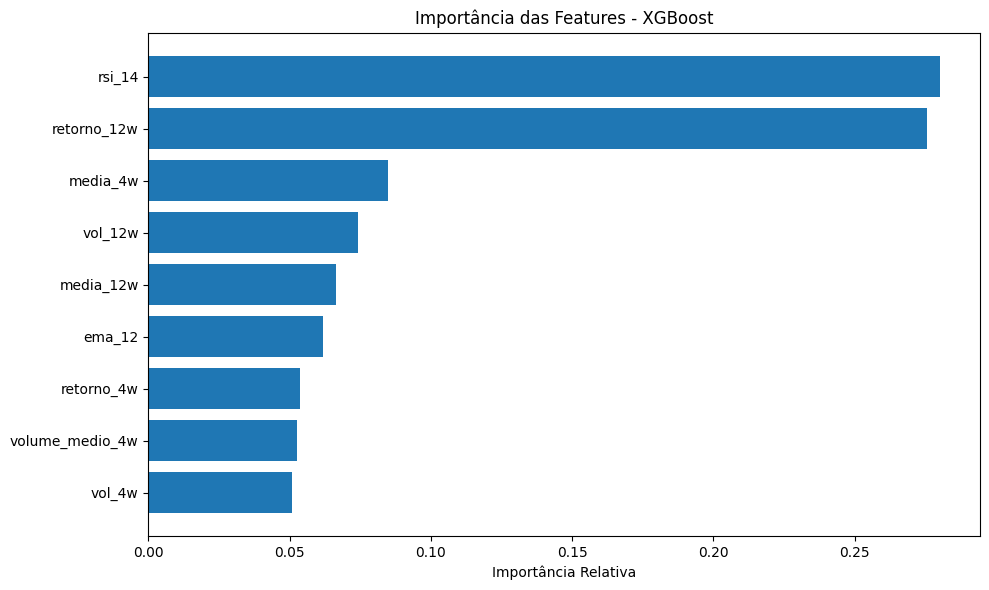


Salvando modelo treinado...
FeatureExtractor()
       cod_negociacao   ano  semana data_pregao  preco_abertura  preco_maximo  \
0              AALL34  2017      10  2017-03-06          140.91        141.31   
1              AALL34  2017      11  2017-03-13          134.07        134.07   
2              AALL34  2017      12  2017-03-20          128.05        128.05   
3              AALL34  2017      15  2017-04-10          134.02        134.02   
4              AALL34  2017      16  2017-04-17          135.79        135.79   
...               ...   ...     ...         ...             ...           ...   
391119         XTED11  2018      48  2018-11-26           17.85         17.86   
391120         XTED11  2018      49  2018-12-03           17.98         18.00   
391121         XTED11  2018      50  2018-12-10           17.03         17.50   
391122         XTED11  2018      51  2018-12-17           16.80         17.99   
391123         XTED11  2018      52  2018-12-26           17.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import r2_score
import pickle

class FeatureExtractor(BaseEstimator, TransformerMixin):
    """Classe para extração avançada de features"""
    def __init__(self):
        self.features_to_use = []
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, df):
        df = df.copy()
        
        # Garantir ordenação correta
        if 'data_pregao' in df.columns:
            df['data_pregao'] = pd.to_datetime(df['data_pregao'])
            df = df.sort_values(['cod_negociacao', 'data_pregao'])
        
        # Grupo para cálculos
        gb = df.groupby('cod_negociacao')['preco_fechamento']
        
        # 1. Médias móveis e volatilidade
        for window in [4, 8, 12, 26]:
            df[f'media_{window}w'] = gb.rolling(window=window).mean().reset_index(level=0, drop=True)
            df[f'vol_{window}w'] = gb.rolling(window=window).std().reset_index(level=0, drop=True)
        
        # 2. Retornos protegidos contra divisão por zero
        def safe_return(current, past, min_price=0.01):
            with np.errstate(divide='ignore', invalid='ignore'):
                return np.where(
                    (past > min_price) & (current > min_price),
                    (current - past) / past,
                    np.nan
                )
        
        for weeks, periods in [(1,0), (4,3), (12,11), (26,25)]:
            preco_passado = gb.shift(periods)
            df[f'retorno_{weeks}w'] = safe_return(df['preco_fechamento'], preco_passado)
        
        # 3. RSI manual (sem TA-Lib)
        def calculate_rsi(series, window=14):
            delta = series.diff()
            gain = delta.where(delta > 0, 0)
            loss = -delta.where(delta < 0, 0)
            
            avg_gain = gain.rolling(window=window, min_periods=1).mean()
            avg_loss = loss.rolling(window=window, min_periods=1).mean()
            
            rs = avg_gain / avg_loss.replace(0, np.nan)
            return 100 - (100 / (1 + rs.replace(np.inf, 100)))
        
        df['rsi_14'] = df.groupby('cod_negociacao')['preco_fechamento'].transform(calculate_rsi)
        
        # 4. Features temporais
        for lag in [1, 2, 3, 4]:
            df[f'retorno_lag_{lag}w'] = df.groupby('cod_negociacao')['retorno_1w'].shift(lag)
        
        df['ema_12'] = df.groupby('cod_negociacao')['preco_fechamento'].transform(
            lambda x: x.ewm(span=12).mean()
        )
        
        # 5. Features de volume
        if 'volume' in df.columns:
            vol_gb = df.groupby('cod_negociacao')['volume']
            for window in [4, 12]:
                df[f'volume_medio_{window}w'] = vol_gb.rolling(window=window).mean().reset_index(level=0, drop=True)
        
        # Definir features a serem usadas
        self.features_to_use = [
            'media_4w', 'media_12w', 'vol_4w', 'vol_12w',
            # 'retorno_1w',
            'retorno_4w', 'retorno_12w',
            # 'retorno_lag_1w', 'retorno_lag_2w',
            'volume_medio_4w', 'ema_12', 'rsi_14'
        ]
        
        return df

def preparar_target(df):
    """Prepara o target com tratamento robusto"""
    df = df.sort_values(['cod_negociacao', 'data_pregao'])
    
    # Calcular retorno futuro de 52 semanas
    df['retorno_futuro'] = df.groupby('cod_negociacao')['preco_fechamento'].transform(
        lambda x: x.pct_change(periods=52)
    )
    
    # Remover outliers extremos
    if 'retorno_futuro' in df.columns:
        lower = df['retorno_futuro'].quantile(0.01)
        upper = df['retorno_futuro'].quantile(0.99)
        df['retorno_futuro'] = df['retorno_futuro'].clip(lower, upper)

    return df

def clean_data(X, y):
    """Limpeza final dos dados"""
    data = X.join(y)
    data = data.replace([np.inf, -np.inf], np.nan)
    data = data.dropna()
    return data.drop('retorno_futuro', axis=1), data['retorno_futuro']

def criar_pipeline_xgb():
    """Pipeline com XGBoost otimizado"""
    return Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', XGBRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.9,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            eval_metric='rmse'
        ))
    ])

def treinar_avaliar_xgb(X, y):
    """Treinamento e avaliação personalizada com validação temporal"""
    tscv = TimeSeriesSplit(n_splits=3)
    scores = []
    modelos = []
    
    for train_index, test_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        
        # Criar e treinar modelo
        xgb = XGBRegressor(
            n_estimators=500,  # Número maior pois usamos early stopping
            learning_rate=0.05,
            max_depth=6,
            subsample=0.9,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            early_stopping_rounds=20,
            eval_metric='rmse'
        )
        
        # Treinar com early stopping
        xgb.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        
        # Avaliar
        y_pred = xgb.predict(X_val)
        score = r2_score(y_val, y_pred)
        scores.append(score)
        modelos.append(xgb)
        
        print(f"Fold {len(scores)}: R² = {score:.4f} | Melhor iteração: {xgb.best_iteration}")
    
    print(f"\nR² Médio: {np.mean(scores):.4f} (±{np.std(scores):.4f})")
    return modelos, scores

def plot_xgb_importance(modelo, feature_names):
    """Visualização da importância das features no XGBoost"""
    importances = modelo.feature_importances_
    
    # Cria DataFrame para melhor visualização
    feat_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance')
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(feat_imp)), feat_imp['Importance'], align='center')
    plt.yticks(range(len(feat_imp)), feat_imp['Feature'])
    plt.title('Importância das Features - XGBoost')
    plt.xlabel('Importância Relativa')
    plt.tight_layout()
    plt.show()

def main(file_path):
    """Função principal"""
    try:
        # 1. Carregar dados
        print("Carregando dados...")
        df = pd.read_csv(file_path)
        
        # 2. Preparar target
        print("\nPreparando target...")
        df = preparar_target(df)
        
        # 3. Extrair features
        print("\nExtraindo features...")
        feature_extractor = FeatureExtractor()
        df_features = feature_extractor.transform(df)
        
        # 4. Selecionar dados finais
        X = df_features[feature_extractor.features_to_use]
        y = df_features['retorno_futuro']
        
        # 5. Limpeza final
        print("\nLimpando dados...")
        X_clean, y_clean = clean_data(X, y)
        
        print(f"\nDados finais: {X_clean.shape[0]} observações")
        print(f"Features: {X_clean.shape[1]} variáveis")
        
        # 6. Treinar e avaliar
        print("\nTreinando XGBoost com validação temporal...")
        modelos, scores = treinar_avaliar_xgb(X_clean, y_clean)
        
        # 7. Treinar modelo final com todos os dados
        print("\nTreinando modelo final...")
        modelo_final = XGBRegressor(
            n_estimators=int(np.mean([m.best_iteration for m in modelos])) + 20,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.9,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        )
        modelo_final.fit(X_clean, y_clean)
        
        # 8. Visualizar importância
        plot_xgb_importance(modelo_final, feature_extractor.features_to_use)

        # 9. Salvar o modelo treinado
        print("\nSalvando modelo treinado...")
        modelo_final.save_model('modelo_xgb_treinado.json')
        
        # Salvar também o feature extractor
        print(feature_extractor)
        print(df_features)
        with open('feature_extractor.pkl', 'wb') as file:
            pickle.dump(feature_extractor, file)
        
        print("Modelo e feature extractor salvos com sucesso!")
        
        return modelo_final, X_clean, y_clean
    
    except Exception as e:
        print(f"\nErro: {str(e)}")
        return None, None, None

if __name__ == "__main__":
    # Executar pipeline
    modelo_xgb, X_data, y_data = main("datasets/acoes_semanais2017_2018.csv")
    
    if modelo_xgb is not None:
        print("\nModelo XGBoost treinado com sucesso!")
        # Exemplo de previsão
        sample_pred = modelo_xgb.predict(X_data.head(1))
        print(f"Exemplo de previsão para a primeira amostra: {sample_pred[0]:.4f}")

In [12]:
modelo_xgb.describe()

count    91321.000000
mean        -0.166043
std          0.419488
min         -0.958333
25%         -0.396154
50%         -0.173913
75%          0.000000
max          2.000000
Name: retorno_futuro, dtype: float64